In [25]:
import os
import PETs_Tool
from anonymeter import evaluators


folder_raw = '.\\data'
folder_SD  = '.\\data_dpsd'



dict_PETs_setting = {'adult' : {'filename'    : '[Adult]'
                               ,'read_params' : {'downcast'       : 'N' # 'Y'
                                                ,'label_encoding' : 'Y'}
                            #    ,'describe_params' : {'data': {'?'}}
                               }
                    }
dict_filename = {'adult': {'raw' : '[Adt Income] adult.csv'
                          }
                }
dict_filename = {key: {**value, 'params': dict_PETs_setting.get(key, {})} 
                 for key, value in dict_filename.items()}
# print(dict_filename)



# update default in SDV
list_adult_SD_SDV_train = ['GaussianCoupula'
                        #    'CoupulaGAN'
                        #   ,'CTGAN'
                        #   ,'GaussianCoupula'
                        #   ,'TVAE'
                          ]
dict_adult_SD_SDV_train = {k: {'sd_params': {'model': k}} for k in list_adult_SD_SDV_train}
dict_filename = {key: PETs_Tool.PETs_util.update_append_nested(value
                                                              ,{'SD_train': dict_adult_SD_SDV_train}
                                                              ) 
                 for key, value in dict_filename.items()}
dict_adult_SD_SDV_train_default = {'sd_params': {'save_model': 'N'}
                                  ,'sample'   : 'Y'
                                  ,'sample_params' : {'sample_rows_as_raw' : 'Y'
                                                     ,'save_data' : 'N'}
                                  }
dict_adult_SD_train = {'SDV' : {key: PETs_Tool.PETs_util.update_append_nested(dict_adult_SD_SDV_train_default
                                                                       ,dict_adult_SD_SDV_train.get(key ,{})
                                                                       )
                                for key in dict_adult_SD_SDV_train
                               }
                      }
dict_filename = {k1: {k2: dict_adult_SD_train if k2 == 'SD_train' else v2
                      for k2 ,v2 in dict_filename[k1].items()
                     } 
                 for k1 in dict_filename
                }
# print(dict_filename)



dict_bootstrap = {'bootstrap_params' : {'bootstrap_time' : 3
                                       ,'sample_ratio'   : 0.8
                                       ,'random_state'   : None
                                       }
                 ,'index_params' : {'index_save'      : 'N'
                                   ,'index_save_data' : 'N'
                                   ,'index_filename'  : 'Anomymeter'
                                   }
                 }
# import json
# print(json.dumps(dict_bootstrap ,indent=4))



for __dataset ,v in dict_filename.items():
    __filename = v['params']['filename']
    print(f"Now is {__filename}: {v['raw']} comparision.")

    __Loader = PETs_Tool.PETs_Loader(os.path.join(folder_raw ,v['raw'])
                                    ,v['params']
                                    )
    __df_ori = __Loader.data
    print(f"Now is {__filename} original data been load: {v['raw']}.")

    dict_boostrap_index = PETs_Tool.PETs_util.df_bootstrap(__df_ori ,dict_bootstrap)

    for __library ,__dict_sd in v['SD_train'].items():
        print(f"Now is {__filename} by library {__library}.")

        for __method ,__params in __dict_sd.items():
            print(f"Now is {__filename} by method {__method} in library {__library}.")

            import copy
            __Loader_bkup = copy.deepcopy(__Loader)
            for time ,dict_idx in dict_boostrap_index.items():
                __df_control  = __Loader.data.loc[dict_boostrap_index[time]['idx_validation']].reset_index(drop=True)
                __Loader.data = __Loader.data.loc[dict_boostrap_index[time]['idx_train'     ]].reset_index(drop=True)
                __df_syn = PETs_Tool.PETs_SD_SDV(__Loader ,__params).synthetic_data

                # recover
                __Loader = __Loader_bkup
                break

                # 20231116, Justyn: refer to
                # https://github.com/statice/anonymeter/blob/main/notebooks/anonymeter_example.ipynb
                # https://storage.googleapis.com/statice-public/anonymeter-datasets



Now is [Adult]: [Adt Income] adult.csv comparision.
Now is [Adult] original data been load: [Adt Income] adult.csv.
Bootstrap df: 3 times is done.
Now is [Adult] by library SDV.
Now is [Adult] by method GaussianCoupula in library SDV.
Metafile loading time: 0.032 sec.
We are execute SingleTable - GaussianCoupula.
Model training time: 23.5003 sec.
Sample as same as raw data: # 48842 rows data by GaussianCoupula in 4.188 秒


In [2]:
__Loader.data.shape

(48842, 15)

In [3]:
__Loader_bkup.data.shape

(48842, 15)

In [26]:
class anonymeter():
    import PETs_Tool
    # from .PETs_Tool           import PETs_SD_SDV
    # from .PETs_Tool.PETs_util import update_append_nested

    def __init__(self ,loader ,idx_ori ,idx_control ,params={}):
        ####### ####### #######
        # init - params       #
        ####### ####### #######
        # input > loader > default
        default_params = {'sd_params': {'metadata'    : 'SingleTable'
                                       ,'save_model': 'N'}
                         ,'sample'   : 'Y'
                         ,'sample_params' : {'sample_rows_as_raw' : 'Y'
                                            ,'save_data' : 'N'}
                         ,'evaluate_params' : {'anonymeter': {'SinglingOut': {'univariate'   : 'Y'
                                                                             ,'multivariate' : 'Y'
                                                                             }
                                                             ,'SinglingOut_params' : {'evaluate_mode' : 'univariate'
                                                                                     ,'n_attacks'     : 500
                                                                                     ,'n_cols'        : 2
                                                                                     }
                                                             ,'SinglingOut_Multi': 'Y'
                                                             }
                                              }
                         }
        self.params = update_append_nested(default_params
                                          ,update_append_nested(loader.params ,params))
        ####### ####### #######
        # init - ori ,ctrl ,syn #
        ####### ####### #######
        __data = loader.data.copy()
        self.data_ori     = __data.loc[idx_ori    ].reset_index(drop=True)
        self.data_control = __data.loc[idx_control].reset_index(drop=True)
        loader.data       = self.data_ori
        self.data_syn     = PETs_Tool.PETs_SD_SDV(loader ,params).synthetic_data
        self.data = __data




    def __SinglingOutEvaluator(self
                              ,n_attacks = 500
                              ):
        # anonymeter\evaluators\singling_out_evaluator.py:97:
        # FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.
        # Use isinstance(dtype, CategoricalDtype) instead elif is_categorical_dtype(values)
        import warnings
        warnings.filterwarnings("ignore" ,category=FutureWarning)

        __evaluator = evaluators.SinglingOutEvaluator(ori       = self.data_ori
                                                     ,syn       = self.data_syn
                                                     ,control   = self.data_control
                                                     ,n_attacks = n_attacks
                                                     )
        



from PETs_Tool.PETs_util import update_append_nested
test = anonymeter(__Loader
          ,idx_ori     = dict_boostrap_index[time]['idx_train'     ]
          ,idx_control = dict_boostrap_index[time]['idx_validation']
          ,params = update_append_nested(__params
                                        ,{'evaluate_params' : {'anonymeter': {'SinglingOut': {'univariate'   : 'Y'
                                                                                             ,'multivariate' : 'N'
                                                                                             }}}})
          )

Metafile loading time: 0.065 sec.
We are execute SingleTable - GaussianCoupula.
Model training time: 20.4795 sec.
Sample as same as raw data: # 48842 rows data by GaussianCoupula in 2.4595 秒


In [27]:

import json
print(json.dumps(test.params ,indent=4))

{
    "sd_params": {
        "metadata": "SingleTable",
        "save_model": "N",
        "model": "GaussianCoupula"
    },
    "sample": "Y",
    "sample_params": {
        "sample_rows_as_raw": "Y",
        "save_data": "N"
    },
    "evaluate_params": {
        "anonymeter": {
            "SinglingOut": {
                "univariate": "Y",
                "multivariate": "N"
            },
            "SinglingOut_params": {
                "evaluate_mode": "univariate",
                "n_attacks": 500,
                "n_cols": 2
            },
            "SinglingOut_Multi": "Y"
        }
    },
    "filename": "[Adult]",
    "read_method": "pandas_csv",
    "read_params": {
        "downcast": "N",
        "label_encoding": "Y",
        "str_col": [],
        "header_exist": "Y",
        "header": [],
        "sheet_name": ""
    }
}


In [8]:


__evaluator = {}
__evaluator['SinglingOutEvaluator'] = {}

__evaluator['SinglingOutEvaluator']['univariate'] =\
    evaluators.SinglingOutEvaluator(ori       = __Loader.data
                                   ,syn       = __df_syn
                                   ,control   = __df_control
                                   ,n_attacks = 500 # 100 # 500
                                   )

try:
    __evaluator['SinglingOutEvaluator']['univariate'].evaluate(mode='univariate')
    print(__evaluator['SinglingOutEvaluator']['univariate'].risk())
    print("Successs rate of main attack:"     ,__evaluator['SinglingOutEvaluator']['univariate'].results().attack_rate)
    print("Successs rate of baseline attack:" ,__evaluator['SinglingOutEvaluator']['univariate'].results().baseline_rate)
    print("Successs rate of control attack:"  ,__evaluator['SinglingOutEvaluator']['univariate'].results().control_rate)
except RuntimeError as ex:
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

Found 203 failed queries out of 500. Check DEBUG messages for more details.


PrivacyRisk(value=0.0, ci=(0.0, 0.02097573058876182))
Successs rate of main attack: SuccessRate(value=0.0593852071649292, error=0.020359586481777707)
Successs rate of baseline attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)
Successs rate of control attack: SuccessRate(value=0.07007466034343092, error=0.022045564284939794)


In [6]:
# anonymeter\evaluators\singling_out_evaluator.py:97:
# FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.
# Use isinstance(dtype, CategoricalDtype) instead elif is_categorical_dtype(values)
import warnings
warnings.filterwarnings("ignore" ,category=FutureWarning)


__evaluator = evaluators.SinglingOutEvaluator(ori     = __Loader.data
                                             ,syn     = __df_syn
                                             ,control = __df_control
                                             ,n_attacks=100 # 500
                                             ,n_cols=2 # 4
                                             )

try:
    __evaluator.evaluate(mode='multivariate')
    __risk = __evaluator.risk()
    print(__risk)
    res = __evaluator.results()
    print(__evaluator.queries()[:3])
except RuntimeError as ex:
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

Found 92 failed queries out of 100. Check DEBUG messages for more details.


KeyboardInterrupt: 

In [7]:
aux_cols = [['age' ,'fnlwgt' ,'race' ,'gender' ,'native-country']
           ,['workclass' ,'education' ,'capital-gain' ,'capital-loss' ,'hours-per-week']
           ]

__evaluator['LinkabilityEvaluator'] =\
    evaluators.LinkabilityEvaluator(ori         = __Loader.data
                                   ,syn         = __df_syn
                                   ,control     = __df_control
                                   ,n_attacks   = 2000 # 100 # 2000
                                   ,aux_cols    = aux_cols
                                   ,n_neighbors = 10)

__evaluator['LinkabilityEvaluator'].evaluate(n_jobs=-2)  # n_jobs follow joblib convention. -1 = all cores, -2 = all execept one
print(__evaluator['LinkabilityEvaluator'].risk())
print("Successs rate of main attack:"     ,__evaluator['LinkabilityEvaluator'].results().attack_rate)
print("Successs rate of baseline attack:" ,__evaluator['LinkabilityEvaluator'].results().baseline_rate)
print("Successs rate of control attack:"  ,__evaluator['LinkabilityEvaluator'].results().control_rate)
print(__evaluator['LinkabilityEvaluator'].risk(n_neighbors=7))

PrivacyRisk(value=0.0, ci=(0.0, 0.002089093912743931))
Successs rate of main attack: SuccessRate(value=0.002455648069704588, error=0.0019453844860661056)
Successs rate of baseline attack: SuccessRate(value=0.003453731022423335, error=0.00238542229400942)
Successs rate of control attack: SuccessRate(value=0.003453731022423335, error=0.00238542229400942)
PrivacyRisk(value=0.0, ci=(0.0, 0.0020787144160350946))


c:\Program Files\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.002455648069704588, baseline = 0.003453731022423335. Analysis results cannot be trusted.
  self._sanity_check()
c:\Program Files\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.001956606593345214, baseline = 0.001956606593345214. Analysis results cannot be trusted.
  self._sanity_check()


c:\Program Files\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.047737348352442026, baseline = 0.05271821456001425. Analysis results cannot be trusted.
  self._sanity_check()
c:\Program Files\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.012871284899436456, baseline = 0.016855977865494236. Analysis results cannot be trusted.
  self._sanity_check()
c:\Program Files\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.07662637235636093, baseline = 0.11248860905088094. Analysis results cannot be trusted.
  self._sanity_check()


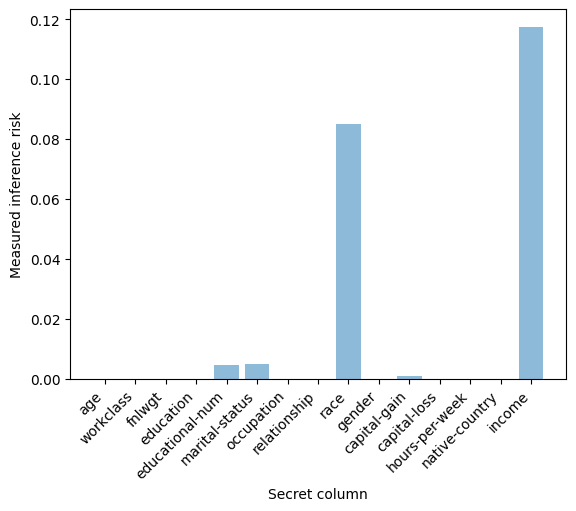

In [6]:
columns = __Loader.data.columns
results = []
__evaluator['InferenceEvaluator'] = {}

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    __evaluator['InferenceEvaluator'][secret]\
        = evaluators.InferenceEvaluator(ori       = __Loader.data
                                       ,syn       = __df_syn
                                       ,control   = __df_control
                                       ,aux_cols  = aux_cols
                                       ,secret    = secret
                                       ,n_attacks = 1000 # 100# 1000
                                       )
    __evaluator['InferenceEvaluator'][secret].evaluate(n_jobs=-2)
    results.append((secret ,__evaluator['InferenceEvaluator'][secret].results()))



import matplotlib.pyplot as plt
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

- 這是已經有檔案的做法 (Unfinished)

In [ ]:
dict_adult_SD_SDV = {'CoupulaGAN'      : ['[Adt Income]_[SDV]_[CoupulaGAN]_20231106_113038_Asia_Taipei_10000.csv']
                    ,'CTGAN'           : ['[Adt Income]_[SDV]_[CTGAN]_20231106_093702_Asia_Taipei_10000.csv']
                    ,'GaussianCoupula' : ['[Adt Income]_[SDV]_[GaussianCoupula]_20231106_093622_Asia_Taipei_10000.csv']
                    ,'TVAE'            : ['[Adt Income]_[SDV]_[TVAE]_20231106_105252_Asia_Taipei_10000.csv']
                    }
dict_filename = {key: {**value ,'SDV': dict_adult_SD_SDV} 
                 for key, value in dict_filename.items()}



for __dataset ,v in dict_filename.items():
    __filename = v['params']['filename']
    print(f"Now is {__filename}: {v['raw']} comparision.")

    __df_ori = PETs_Tool.PETs_Loader(os.path.join(folder_raw ,v['raw'])
                                    ,v['params']
                                    ).data
    print(f"Now is {__filename} original data been load: {v['raw']}.")

    for __library ,__dict_sd in v['SD'].items():
        print(f"Now is {__filename} by library {__library}.")

        for __method ,__list_sd in __dict_sd.items():
            print(f"Now is {__filename} by method {__method} in library {__library}.")
            __list_sd = [__list_sd] if isinstance(__list_sd ,str) else __list_sd
            for __filename_sd in __list_sd:
                # 20231116, Justyn: 這裡是合成資料有落地
                #                   如果必要，可以直接調用 PETs_SD_* 結果的.synthetic_data
                __df_syn = PETs_Tool.PETs_Loader(os.path.join(folder_SD ,__filename_sd)
                                                ,v['params']
                                                ).data
                print(f"Now is {__filename} synthetic data been load: {__filename_sd}.")

                # 20231116, Justyn: refer to
                # https://github.com/statice/anonymeter/blob/main/notebooks/anonymeter_example.ipynb
                # https://storage.googleapis.com/statice-public/anonymeter-datasets

